In [1]:
from gpcam import GPOptimizer

import torch
from torch import nn

import numpy as np
from numpy.random import default_rng

import matplotlib.pyplot as plt
import plotly.graph_objects as go

import os
import csv

import random

import scipy.io


In [2]:
def plot(x, y, xlabel = "x", ylabel = 'y'):
    plt.figure(figsize = (20,10))
    plt.plot(x,y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

def scatter(x,y, xlabel = "x", ylabel = 'y'):
    plt.figure(figsize = (20,10))
    plt.scatter(x,y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

def plotUQ(x, y, var, xlabel = "x", ylabel = 'y'):
    plt.figure(figsize = (20,10))
    plt.plot(x,y)
    plt.fill_between(x,y - 3. * np.sqrt(var), y + 3. * np.sqrt(var), alpha = 0.5, color = "grey")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

def plot_model(x, y, var , data = (), xlabel = "x", ylabel = 'y'):
    plt.figure(figsize = (20,10))
    plt.plot(x,y)
    plt.scatter(data[0],data[1], color = "black")
    plt.fill_between(x,y - 1. * np.sqrt(var), y + 1. * np.sqrt(var), alpha = 0.5, color = "grey")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.ylim(np.min(y_data),np.max(y_data))
    plt.show()


**Loading the Data**

In [3]:
# Load the Matlab file
capacity = scipy.io.loadmat("/data/Dataset 2/YData.mat")
cycle_life = scipy.io.loadmat("/data/Dataset 2/XData.mat")


# Extract the cell array from the Matlab file
capacity = capacity['YData']
cycle_life = cycle_life['XData']

# Convert the cell array to a NumPy array
capacity = np.asarray(capacity)
cycle_life = np.asarray(cycle_life)

x_data_original = []
y_data_original = []

for i in range(48):
    x_data_original.append(cycle_life[0][i].flatten())
    y_data_original.append(capacity[0][i].flatten())

x_data_original = np.asarray(x_data_original, dtype=object)
y_data_original = np.asarray(y_data_original, dtype=object)


# Preparing the data for Fitting
x_data = np.concatenate(x_data_original, axis=None).reshape(-1,1)
y_data = np.concatenate(y_data_original, axis=None).reshape(-1,1)


label_size = 30
plt.figure(figsize = (20,10))

for i in range(len(x_data_original)): plt.scatter(x_data_original[i],y_data_original[i])
plt.tick_params(axis='both', which='major', labelsize=label_size) # Set the font size of the tick labels on the x and y axes
plt.xlabel("Cycle Number",fontsize=label_size)
plt.ylabel("Capacity",fontsize=label_size)
plt.show()


# Creating the Subfolder in Results

In [1]:
# Specify the path for the new folder
new_folder_path = f"/results/Dataset 2 Figures/Training NN/"

# Create the folder
os.makedirs(new_folder_path, exist_ok=True)

NameError: name 'os' is not defined

# Deep Kernel Learning

In [4]:
# All remaining code asssumes that the NN architecture is made up of two hidden layers and same number of nodes
# If other architectures are used, the indices of the hyperparameters and their boudsn need to be changed accordingly
# Number of nodes can be varied as the user prefer

class Network(nn.Module):
    def __init__(self):
        super().__init__()

        self.nodes_num = 5

        # Inputs to hidden layer linear transformation
        self.layer1 = nn.Linear(1, self.nodes_num)
        self.layer2 = nn.Linear(self.nodes_num, self.nodes_num)
        self.layer3 = nn.Linear(self.nodes_num, 1)

    def forward(self, x):
        # Pass the input tensor through each of our operations
        #print(x)
        x = torch.Tensor(x)
        x = torch.nn.functional.relu(self.layer1(x))
        x = torch.nn.functional.relu(self.layer2(x))
        x = torch.nn.functional.relu(self.layer3(x))
        return x.detach().numpy()

    def set_weights(self,w1,w2,w3):
      with torch.no_grad():
        self.layer1.weight = nn.Parameter(torch.from_numpy(w1).float())
        self.layer2.weight = nn.Parameter(torch.from_numpy(w2).float())
        self.layer3.weight = nn.Parameter(torch.from_numpy(w3).float())

    def set_biases(self,b1,b2,b3):
      with torch.no_grad():
        self.layer1.bias = nn.Parameter(torch.from_numpy(b1).float())
        self.layer2.bias = nn.Parameter(torch.from_numpy(b2).float())
        self.layer3.bias = nn.Parameter(torch.from_numpy(b3).float())

    def get_weights(self):
        return self.layer1.weight, self.layer2.weight, self.layer3.weight
    def get_biases(self):
        return self.layer1.bias, self.layer2.bias, self.layer3.bias

n = Network()


# Defining the GP Components

In [5]:
# For the squared Exponential Function
def get_distance_matrix(x1,x2):
    d = np.zeros((len(x1),len(x2)))
    for i in range(x1.shape[1]):
        d += (x1[:,i].reshape(-1, 1) - x2[:,i])**2
    return np.sqrt(d)

# For the Noise
def s(x, my_slope, my_pow, my_intercept):
    o = my_slope * x**my_pow + my_intercept
    return o

def my_noise(x,hps,obj):

    total_num_of_NN_hps =  np.int(obj.args[1])
    
    my_slope     = hps[total_num_of_NN_hps+1]
    my_pow       = hps[total_num_of_NN_hps+2]
    my_intercept = hps[total_num_of_NN_hps+3]

    my_s = s(x,my_slope,my_pow,my_intercept)

    noise = np.diag(my_s[:,0])
    
    return noise

# Kernel Function
def kernel_nn(x1,x2,hps,obj):

    nodes_num           = np.int(obj.args[0])
    total_num_of_NN_hps = np.int(obj.args[1])

    # NN
    n.set_weights(hps[0:nodes_num].reshape(nodes_num,1),
                  hps[nodes_num:nodes_num**2+nodes_num].reshape(nodes_num,nodes_num),
                  hps[nodes_num**2+nodes_num:nodes_num**2+2*nodes_num].reshape(1,nodes_num))

    n.set_biases(hps[nodes_num**2+2*nodes_num:nodes_num**2+3*nodes_num].reshape(nodes_num),
                 hps[nodes_num**2+3*nodes_num:nodes_num**2+4*nodes_num].reshape(nodes_num),
                 np.array([hps[nodes_num**2+4*nodes_num]]))

    x1_nn = n.forward(x1).reshape(-1,1)
    x2_nn = n.forward(x2).reshape(-1,1)
    d = get_distance_matrix(x1_nn,x2_nn)


    # Main Function
    k = hps[total_num_of_NN_hps] * obj.squared_exponential_kernel(d, 1000) #100

    return k


################################################################################

# Mean function: Two-Element piecewise function
def mean2(x,hps,obj):

    total_num_of_NN_hps =  np.int(obj.args[1])

    x0 = hps[total_num_of_NN_hps+4]
    
    m1 = hps[total_num_of_NN_hps+5]
    m2 = hps[total_num_of_NN_hps+6]

    b1 = obj.args[2]
    b2 = (m1 - m2) * x0 + b1

    x = x[:,0]

    y = np.where(x <= x0, m1*x + b1, m2*x + b2)
                
    return y

# Fitting GP Model

In [ ]:
x_pred = np.linspace(0,2000,2001).reshape(-1,1)

nodes_num = n.nodes_num

total_num_of_NN_hps = nodes_num**2 + 4*nodes_num + 1     # Depends on the number of layers used
num_of_other_hps = 7                                     # Depends on Kernel, noise and mean functions

NN_weights_initial_hps = np.random.uniform(0, 2,nodes_num**2+2*nodes_num)
NN_biases_initial_hps = np.random.uniform(0, 2,total_num_of_NN_hps-(nodes_num**2+2*nodes_num))


other_init_hps = np.array([1,                # Kernel
                           1e-4, 2, 0.,             # Noise
                           1000,-3e-4,-15e-4])        # Mean


init_hyperparameters = np.concatenate([NN_weights_initial_hps,NN_biases_initial_hps,other_init_hps])



# Finding the mean of the initial capacity to be entered to the code
my_ind = np.where(x_data<=10)
initial_capacity = np.mean(y_data[my_ind[0]])


print("x data: ", x_data.shape)
print("y data: ", y_data.shape)


'''
trained_hps = np.array([-1.28686427e+00, -1.60725421e+00,  9.85409674e-01,  1.25991948e+00,
       -4.40574632e-01,  2.98474828e-01, -4.74403310e-01,  6.82552567e-01,
        3.34457885e-01, -7.11505837e-01, -1.08521902e+00,  7.22721459e-01,
        6.76280002e-01, -6.08126099e-01,  1.66262519e+00,  9.97179038e-01,
       -4.34492112e-01,  1.85174641e+00, -1.67960358e+00, -7.71786758e-02,
       -1.45822560e+00, -1.81917804e+00,  5.60073554e-01,  2.17711942e-01,
        8.36540604e-01,  2.58496319e-01, -9.45888376e-01, -2.23325231e-01,
        1.75549917e+00, -1.98276680e+00, -2.41103600e-01,  4.36082108e-01,
       -1.75011179e+00, -1.30060444e-01,  9.70980318e-01, -1.09978910e+00,
       -1.59784829e+00, -5.48620850e-01, -9.71466113e-01,  1.10481678e+00,
       -2.34875903e-01,  1.85192530e+00,  1.58140506e+00,  1.39725758e-01,
        4.68372858e-01,  3.65868303e-01,  7.62834647e+00,  2.83628137e-06,
        1.16996004e+00,  4.86370802e-05,  1.18012239e+03, -3.51597520e-04,
       -7.06191837e-04])
'''

my_gpNN1 = GPOptimizer(x_data,y_data,
            init_hyperparameters = init_hyperparameters,  # we need enough of those for kernel, noise and prior mean functions
            #noise_variances=np.ones(y_data.shape) * 0.01, #provding noise variances and a noise function will raise a warning 
            compute_device='cpu', 
            gp_kernel_function=kernel_nn, 
            gp_kernel_function_grad=None, 
            gp_mean_function=mean2, 
            gp_mean_function_grad=None,
            gp_noise_function=my_noise,
            normalize_y=False,
            sparse_mode=False,
            gp2Scale = False,
            store_inv=False, 
            ram_economy=False, 
            args=np.array([nodes_num, total_num_of_NN_hps, initial_capacity]))


# Setting the Optimization Bounds for Hyperparameters
bounds = np.empty((total_num_of_NN_hps + num_of_other_hps,2))

# NN
bounds[0:nodes_num**2+2*nodes_num] = np.array([-2.,2.])                      # Weights NN: Define spread and shift in output
bounds[nodes_num**2+2*nodes_num:total_num_of_NN_hps] = np.array([-2.,2.])    # Biases of NN: Define shift in output

# Kernel Sq Exp 
bounds[total_num_of_NN_hps] = np.array([1e-3,10.]) # 200                             # Kernel Variance
#bounds[1] = np.array([100.,1500.])                           # Kernel Lengthscale

# Noise
bounds[total_num_of_NN_hps+1] = np.array([1e-11,1.])                           # Noise Slope
bounds[total_num_of_NN_hps+2] = np.array([1.1,3.])                            # Noise Power
bounds[total_num_of_NN_hps+3] = np.array([0.,1.])                              # Noise Intercept
# Mean
bounds[total_num_of_NN_hps+4] = np.array([600.,1600.])                          # Mean Piecewise Intersection point
bounds[total_num_of_NN_hps+5] = np.array([-6e-4,-2e-4])                        # Mean Slope 1
bounds[total_num_of_NN_hps+6] = np.array([-20e-4,-3e-4])                        # Mean Slope 2


my_gpNN1.train(hyperparameter_bounds=bounds,max_iter = 50)

print("Training is Done")


x data:  (777, 1)
y data:  (777, 1)


/tmp/ipykernel_5659/1557931094.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  total_num_of_NN_hps =  np.int(obj.args[1])
/tmp/ipykernel_5659/1557931094.py:58: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in Num

hps:  [-1.28686427e+00 -1.60725421e+00  9.85409674e-01  1.25991948e+00
 -4.40574632e-01  2.98474828e-01 -4.74403310e-01  6.82552567e-01
  3.34457885e-01 -7.11505837e-01 -1.08521902e+00  7.22721459e-01
  6.76280002e-01 -6.08126099e-01  1.66262519e+00  9.97179038e-01
 -4.34492112e-01  1.85174641e+00 -1.67960358e+00 -7.71786758e-02
 -1.45822560e+00 -1.81917804e+00  5.60073554e-01  2.17711942e-01
  8.36540604e-01  2.58496319e-01 -9.45888376e-01 -2.23325231e-01
  1.75549917e+00 -1.98276680e+00 -2.41103600e-01  4.36082108e-01
 -1.75011179e+00 -1.30060444e-01  9.70980318e-01 -1.09978910e+00
 -1.59784829e+00 -5.48620850e-01 -9.71466113e-01  1.10481678e+00
 -2.34875903e-01  1.85192530e+00  1.58140506e+00  1.39725758e-01
  4.68372858e-01  3.65868303e-01  7.62834647e+00  2.83628137e-06
  1.16996004e+00  4.86370802e-05  1.18012239e+03 -3.51597520e-04
 -7.06191837e-04]


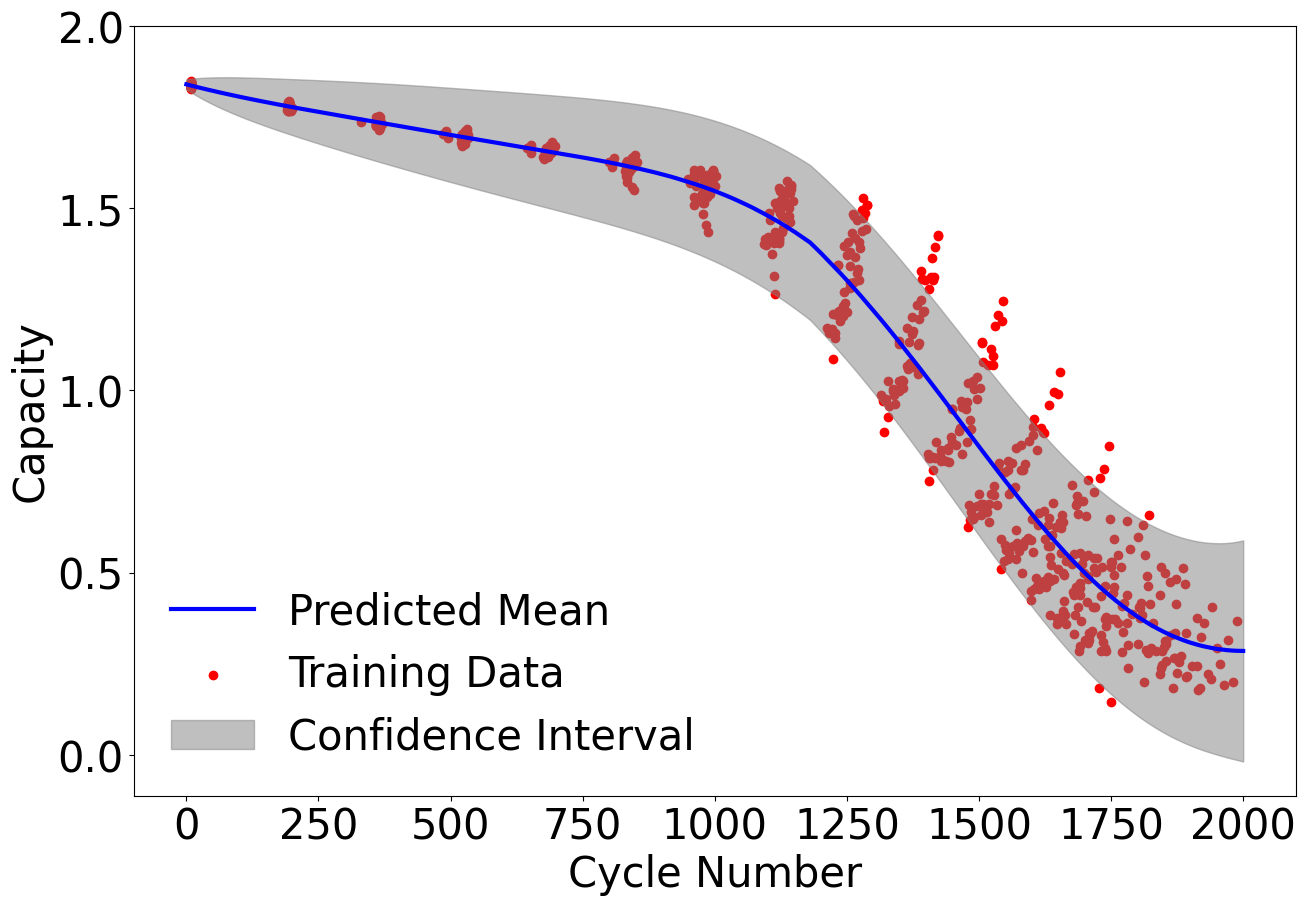

In [91]:
#print("hps: ", my_gpo.hyperparameters)
f = my_gpNN1.posterior_mean(x_pred)["f(x)"]
v = my_gpNN1.posterior_covariance(x_pred, add_noise=True)["v(x)"]

print("hps: ", my_gpNN1.hyperparameters)

# Plotting the data
plt.figure(figsize = (15,10))
plt.plot(x_pred[:,0],f, color = "blue", linewidth = 3,label="Predicted Mean")
plt.scatter(x_data[:,0],y_data, color = "red",label="Training Data") # All Data
plt.fill_between(x_pred[:,0],f - 2. * np.sqrt(v), f + 2. * np.sqrt(v), alpha = 0.5, color = "grey",label="Confidence Interval")
plt.tick_params(axis='both', which='major', labelsize=label_size) # Set the font size of the tick labels on the x and y axes
plt.xlabel("Cycle Number",fontsize=label_size)
plt.ylabel("Capacity",fontsize=label_size)
plt.legend(loc='best',fontsize=label_size,frameon=False)
# Set the y-axis ticks
#plt.ylim(0,2)
plt.yticks(np.arange(0, 2.1, 0.5))
plt.savefig('/results/Dataset 2 Figures/No Stopping/Ground Truth Fit.png') # saving plot with a unique name 

In [97]:
my_gpNN1.hyperparameters

array([-1.28686427e+00, -1.60725421e+00,  9.85409674e-01,  1.25991948e+00,
       -4.40574632e-01,  2.98474828e-01, -4.74403310e-01,  6.82552567e-01,
        3.34457885e-01, -7.11505837e-01, -1.08521902e+00,  7.22721459e-01,
        6.76280002e-01, -6.08126099e-01,  1.66262519e+00,  9.97179038e-01,
       -4.34492112e-01,  1.85174641e+00, -1.67960358e+00, -7.71786758e-02,
       -1.45822560e+00, -1.81917804e+00,  5.60073554e-01,  2.17711942e-01,
        8.36540604e-01,  2.58496319e-01, -9.45888376e-01, -2.23325231e-01,
        1.75549917e+00, -1.98276680e+00, -2.41103600e-01,  4.36082108e-01,
       -1.75011179e+00, -1.30060444e-01,  9.70980318e-01, -1.09978910e+00,
       -1.59784829e+00, -5.48620850e-01, -9.71466113e-01,  1.10481678e+00,
       -2.34875903e-01,  1.85192530e+00,  1.58140506e+00,  1.39725758e-01,
        4.68372858e-01,  3.65868303e-01,  7.62834647e+00,  2.83628137e-06,
        1.16996004e+00,  4.86370802e-05,  1.18012239e+03, -3.51597520e-04,
       -7.06191837e-04])

Text(0.5, 1.0, 'Cycle Number')

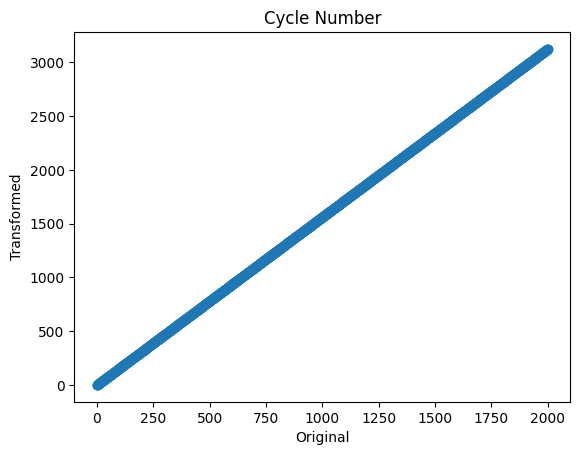

In [93]:
x_pred_nn = n.forward(x_pred)

plt.scatter(x_pred,x_pred_nn)
plt.xlabel("Original")
plt.ylabel("Transformed")
plt.title("Cycle Number")

hps:  [-1.28686427e+00 -1.60725421e+00  9.85409674e-01  1.25991948e+00
 -4.40574632e-01  2.98474828e-01 -4.74403310e-01  6.82552567e-01
  3.34457885e-01 -7.11505837e-01 -1.08521902e+00  7.22721459e-01
  6.76280002e-01 -6.08126099e-01  1.66262519e+00  9.97179038e-01
 -4.34492112e-01  1.85174641e+00 -1.67960358e+00 -7.71786758e-02
 -1.45822560e+00 -1.81917804e+00  5.60073554e-01  2.17711942e-01
  8.36540604e-01  2.58496319e-01 -9.45888376e-01 -2.23325231e-01
  1.75549917e+00 -1.98276680e+00 -2.41103600e-01  4.36082108e-01
 -1.75011179e+00 -1.30060444e-01  9.70980318e-01 -1.09978910e+00
 -1.59784829e+00 -5.48620850e-01 -9.71466113e-01  1.10481678e+00
 -2.34875903e-01  1.85192530e+00  1.58140506e+00  1.39725758e-01
  4.68372858e-01  3.65868303e-01  7.62834647e+00  2.83628137e-06
  1.16996004e+00  4.86370802e-05  1.18012239e+03 -3.51597520e-04
 -7.06191837e-04]


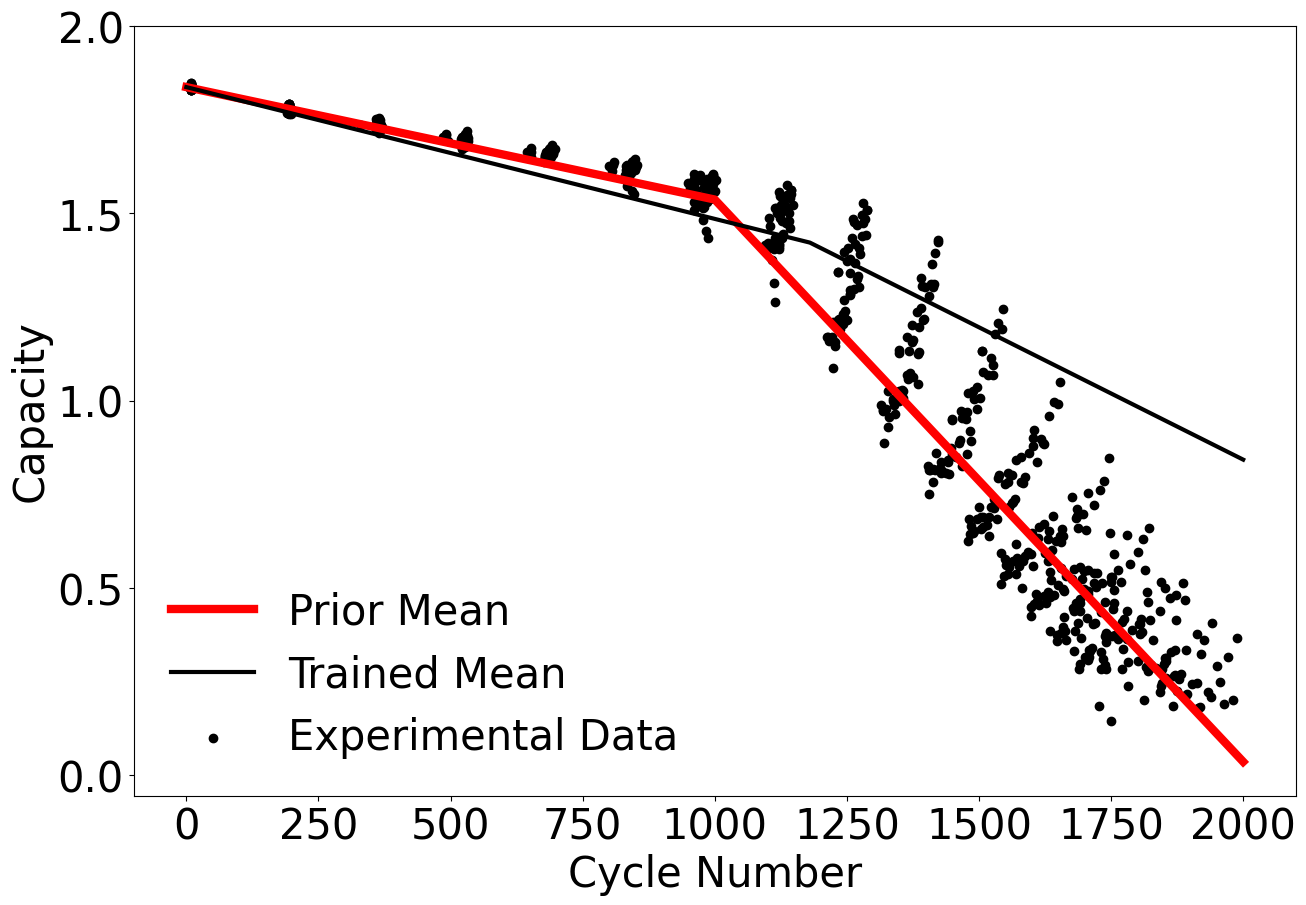

In [95]:
# Plotting the prior
print("hps: ", my_gpNN1.hyperparameters)

class MyObject:
    args = np.array([nodes_num, total_num_of_NN_hps, initial_capacity])
obj = MyObject()

prior_y = mean2(x_pred,init_hyperparameters,obj)
trained_prior_y = mean2(x_pred,my_gpNN1.hyperparameters,obj)
#prior_y

# Plotting the data
plt.figure(figsize = (15,10))
plt.plot(x_pred[:,0],prior_y, color = "red", linewidth = 6, label = "Prior Mean")
plt.plot(x_pred[:,0],trained_prior_y, color = "black", linewidth = 3, label = "Trained Mean")
plt.scatter(x_data[:,0],y_data, color = "black",label = "Experimental Data") # All Data
plt.tick_params(axis='both', which='major', labelsize=label_size) # Set the font size of the tick labels on the x and y axes

plt.xlabel("Cycle Number",fontsize=label_size)
plt.ylabel("Capacity",fontsize=label_size)
plt.legend(fontsize=label_size,frameon=False)
plt.yticks(np.arange(0, 2.1, 0.5))

plt.show()

2.8362813735971493e-06
1.1699600403451784
4.8637080179825265e-05


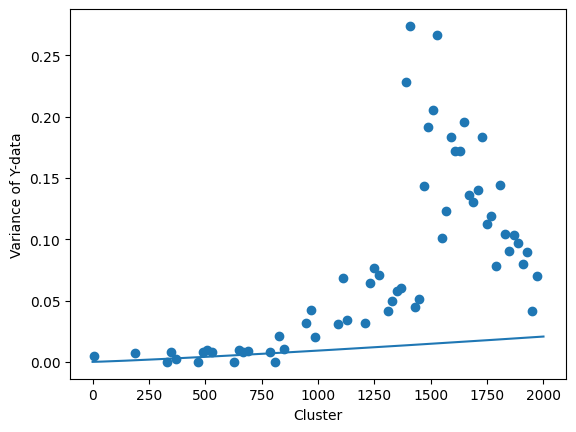

In [96]:
# Calculating the Variance for noise

# Define the range of x values for each cluster
x_ranges = np.linspace(np.min(x_data), np.max(x_data), num=100)

# Find the variance of y data for each cluster
variances = []
for i in range(len(x_ranges)-1):
    mask = np.logical_and(x_data >= x_ranges[i], x_data <= x_ranges[i+1])
    cluster_y_data = y_data[mask]
    variance = np.std(cluster_y_data)
    variances.append(variance)

variances = np.array(variances)


my_xdata_here = np.linspace(0,2000,1001)

my_slope  = my_gpNN1.hyperparameters[total_num_of_NN_hps+1]
my_pow    = my_gpNN1.hyperparameters[total_num_of_NN_hps+2]
my_offset = my_gpNN1.hyperparameters[total_num_of_NN_hps+3]

print(my_slope)
print(my_pow)
print(my_offset)

predicted_variability =s(my_xdata_here, my_slope, my_pow, my_offset)


# scatter plot the variances
plt.scatter(x_ranges[0:-1], variances)
plt.plot(my_xdata_here,predicted_variability)

plt.xlabel('Cluster')
plt.ylabel('Variance of Y-data')
plt.show()